In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import numpy as np
import scipy as sp
import patsy
from patsy.contrasts import Helmert
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from tableone import TableOne
from statsmodels.graphics.factorplots import interaction_plot
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.packages import importr
from rpy2.robjects import Formula
utils = importr('utils')
lme4 = importr('lme4')
#utils.install_packages('glmnet')
stats_ = importr('stats')
#glmnet = importr('glmnet')
#lme4 = importr('lme4')
#library(lmerTest)
R = ro.r

/afs/crc.nd.edu/user/l/lfaust/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<b><font size="4">Setup + cleaning</font></b>

In [2]:
#Helper functions
def AgeType(x):
    x = int(x)
    if(pd.isnull(x)):
        return(-1)
    if(x<=18):
        return 18
    if(x<=24):
        return 24
    if(x<=53):
        return 53
    if(x<=77):
        return 77
    if(x<=89):
        return 89
    if(x>90):
        return 90
    return 0

def DiagCodeType(x):
    if(pd.isnull(x)):
        return(0)
    if(not str(x).isnumeric()):
        return 1
    x = int(str(x[0:3]))
    if((x>=0)&(x<=139)):
        return 2
    if((x>=140)&(x<=239)):
        return 3
    if((x>=240)&(x<=279)):
        return 4
    if((x>=280)&(x<=289)):
        return 5
    if((x>=290)&(x<=319)):
        return 6
    if((x>=320)&(x<=389)):
        return 7
    if((x>=390)&(x<=459)):
        return 8
    if((x>=460)&(x<=519)):
        return 9
    if((x>=520)&(x<=579)):
        return 10
    if((x>=580)&(x<=629)):
        return 11
    if((x>=630)&(x<=679)):
        return 12
    if((x>=680)&(x<=709)):
        return 13
    if((x>=710)&(x<=739)):
        return 14
    if((x>=740)&(x<=759)):
        return 15
    if((x>=760)&(x<=779)):
        return 16
    if((x>=780)&(x<=799)):
        return 17
    if((x>=800)&(x<=999)):
        return 18
    return 0

def DiagCodeAbbv(x):
    if(pd.isnull(x)):
        return(0)
    if(not str(x).isnumeric()):
        return 1
    x = int(str(x[0:3]))
    return x

In [3]:
df = pd.read_pickle('pat_data.pkl')

In [4]:
#Cleaning
df['Primary_Diag_Code'] = df['Primary_Diag'].apply(lambda x: DiagCodeType(x))
df['DiagCodeAbbv'] = df['Primary_Diag'].apply(lambda x: DiagCodeAbbv(x))
#print(df[df.Primary_Diag_Code <= 0].shape)
#df = df[df.Primary_Diag_Code > 0]
df['Age'] = df['Age'].apply(lambda x: AgeType(x))
df = df.replace(to_replace=['UNABLE TO OBTAIN','UNKNOWN/NOT SPECIFIED','PATIENT DECLINED TO ANSWER'], value='UNKNOWN')
df = df.replace(to_replace=['ASIAN - CHINESE','ASIAN - VIETNAMESE','ASIAN - ASIAN INDIAN','ASIAN - FILIPINO','ASIAN - KOREAN','ASIAN - OTHER','ASIAN - CAMBODIAN','ASIAN - JAPANESE','ASIAN - THAI'], value='ASIAN')
df = df.replace(to_replace=['HISPANIC/LATINO - PUERTO RICAN','HISPANIC/LATINO - DOMINICAN','HISPANIC/LATINO - GUATEMALAN','HISPANIC/LATINO - SALVADORAN','HISPANIC/LATINO - CUBAN','HISPANIC/LATINO - MEXICAN','HISPANIC/LATINO - COLOMBIAN','HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)','HISPANIC/LATINO - HONDURAN'], value='HISPANIC OR LATINO')
df = df.replace(to_replace=['BLACK/AFRICAN AMERICAN','BLACK/CAPE VERDEAN','BLACK/HAITIAN','BLACK/AFRICAN'], value='BLACK')
df = df.replace(to_replace=['WHITE - RUSSIAN','WHITE - OTHER EUROPEAN','WHITE - BRAZILIAN','WHITE - EASTERN EUROPEAN'], value='WHITE')
df = df.replace(to_replace=['MULTI RACE ETHNICITY','AMERICAN INDIAN/ALASKA NATIVE','PORTUGUESE','MIDDLE EASTERN','NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER','SOUTH AMERICAN','CARIBBEAN ISLAND','AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE'], value='OTHER')
print(df[(df.Admit_Type == 'NEWBORN')].shape)
df = df[df.Admit_Type != 'NEWBORN']
print(df[(df.Admit_Unit == 'NICU')].shape)
df = df[df.Admit_Unit != 'NICU']
print(df.shape)
df = df[df.Lag_Time > 0]
print(df.shape)
df = df.replace(to_replace=['TRANSFER FROM SKILLED NUR','TRANSFER FROM OTHER HEALT','TRSF WITHIN THIS FACILITY','TRANSFER FROM HOSP/EXTRAM'], value='TRANSFER')
df = df[df.Admit_LOC.isin(['EMERGENCY ROOM ADMIT','TRANSFER','CLINIC REFERRAL/PREMATURE','PHYS REFERRAL/NORMAL DELI'])]
df = df.replace(to_replace=['CLINIC REFERRAL/PREMATURE','PHYS REFERRAL/NORMAL DELI'], value='REFERRAL')
df.loc[(df.DOW == 5)|(df.DOW == 6), 'weekend'] = 1
df.loc[(df.DOW == 6)&(df.TOD == 'Night'), 'weekend'] = 1
df.weekend = df.weekend.fillna(0)
df['LOS_ICU_o'] = df['LOS_ICU']
df['LOS_ICU'] = pd.qcut(df['LOS_ICU'], 4,False)
df['Hospital_LOS'] = pd.qcut(df['Hospital_LOS'], 4,False)

(7580, 23)
(43, 23)
(30746, 23)
(30746, 23)


In [5]:
df.shape

(30741, 25)

In [6]:
icu_stay_table = pd.read_csv('../MIMICIII/ICUSTAYS.csv')
icu_stay_table.INTIME = pd.to_datetime(icu_stay_table.INTIME)
df.ICU_Time = pd.to_datetime(df.ICU_Time)
df = df.merge(icu_stay_table[['HADM_ID','ICUSTAY_ID','INTIME']], left_on=['hadm_id','ICU_Time'], right_on=['HADM_ID','INTIME']).drop(['HADM_ID','INTIME'],1)

In [7]:
oasis = pd.read_csv('../views/oasis.csv')
df = df.merge(oasis[['hadm_id','icustay_id','oasis_prob']], left_on=['hadm_id','ICUSTAY_ID'], right_on=['hadm_id','icustay_id'], how='left')
df['oasis_prob'] = pd.qcut(df['oasis_prob'],4,labels=['a','b','c','d']).astype(str)

In [8]:
df = df.drop(['ICUSTAY_ID','icustay_id'],1)

In [9]:
df.shape

(30741, 26)

<b><font size="4">Summary stats</font></b>

In [10]:
columns = ['Admit_Type', 'Admit_LOC', 'Insurance', 'Expire', 'Admit_Unit', 'LOS_ICU', 'NoICU', 'Transfer_Flag', 'Age', 'Hospital_LOS', 'TOD', 'Primary_Diag_Code', 'Ethnicity', 'Gender', 'oasis_prob']
groupby = 'weekend'
pval = True
TableOne(df, columns=columns, categorical=columns, groupby=groupby, pval=pval).tableone

/afs/crc.nd.edu/user/l/lfaust/anaconda3/lib/python3.6/site-packages/tableone.py:405: UserWarning: No p-value was computed for Primary_Diag_Code due to the low number of observations.
  warnings.warn('No p-value was computed for {} due to the low number of observations.'.format(v))


Grouped by weekend                 \
                                                   isnull            0.0   
variable          level                                                    
n                                                                  24063   
Admit_Type        ELECTIVE                              0   4543 (18.88)   
                  EMERGENCY                                19017 (79.03)   
                  URGENT                                      503 (2.09)   
Admit_LOC         EMERGENCY ROOM ADMIT                  0    9289 (38.6)   
                  REFERRAL                                  9882 (41.07)   
                  TRANSFER                                  4892 (20.33)   
Insurance         Government                            0     683 (2.84)   
                  Medicaid                                   1833 (7.62)   
                  Medicare                                 12669 (52.65)   
                  Private                                   8555 (35.55)   
                  Self Pay                                    323 (1.34)   
Expire            0                                     0  20920 (86.94)   
                  1                                         3143 (13.06)   
Admit_Unit        CCU                                   0   3382 (14.05)   
                  CSRU                                      5784 (24.04)   
                  MICU                                      7745 (32.19)   
                  SICU                                       3899 (16.2)   
                  TSICU                                     3253 (13.52)   
LOS_ICU           0                                     2   6194 (25.74)   
                  1                                         6049 (25.14)   
                  2.0                                       5932 (24.65)   
                  3.0                                       5886 (24.46)   
NoICU             0                                     0  12346 (51.31)   
                  1                                        11717 (48.69)   
Transfer_Flag     0                                     0   21800 (90.6)   
                  1                                           2263 (9.4)   
Age               18                                    0     137 (0.57)   
                  24                                          559 (2.32)   
                  53                                         5703 (23.7)   
                  77                                        11646 (48.4)   
                  89                                        4838 (20.11)   
                  90                                          1180 (4.9)   
Hospital_LOS      0                                     0   5622 (23.36)   
                  1                                         6125 (25.45)   
                  2.0                                       6388 (26.55)   
                  3.0                                       5928 (24.64)   
TOD               Day                                   0  13651 (56.73)   
                  Night                                    10412 (43.27)   
Primary_Diag_Code 0                                     0        1 (0.0)   
                  1                                            63 (0.26)   
                  2.0                                        1584 (6.58)   
                  3.0                                        2050 (8.52)   
                  4                                           472 (1.96)   
                  5                                            84 (0.35)   
                  6                                            168 (0.7)   
                  7                                           393 (1.63)   
                  8                                        10302 (42.81)   
                  9                                          1605 (6.67)   
                  10                                         2047 (8.51)   
           

<b><font size="4">testing significance of interactions</font></b>

In [11]:
sigVars = []

In [12]:
rdf=pandas2ri.py2ri(df)

fmlNull = Formula('dv ~ (1|id)')
fmlModel = Formula('dv ~ cluster + (1|id)')
#fmlGender = Formula('cluster ~ gender*dv + (1|id)')
resultNull = lme4.lmer(fmlNull,data=rdf, REML=False)
resultModel = lme4.lmer(fmlModel,data=rdf, REML=False)
#resultGender = lme4.glmer(fmlGender,data=rdf, REML=False, family = 'binomial')
#print(R.summary(resultModel))
#print()
print(R.anova(resultNull,resultModel,type="marginal"))

full = Formula("Expire ~ 1+ factor(TOD)*factor(weekend) + factor(Admit_LOC)*factor(weekend) + factor(Admit_Type)*factor(weekend) + factor(Admit_Unit)*factor(weekend) + factor(Age)*factor(weekend) + factor(Gender)*factor(weekend) + factor(Ethnicity)*factor(weekend) + factor(Hospital_LOS)*factor(weekend) + factor(Insurance)*factor(weekend) + factor(LOS_ICU)*factor(weekend) + factor(Primary_Diag_Code)*factor(weekend) + factor(Transfer_Flag)*factor(weekend) + (1|oasis_prob)")
null = Formula("Expire ~ 1+ factor(TOD)*factor(weekend) + factor(Admit_LOC)*factor(weekend) + factor(Admit_Type)*factor(weekend) + factor(Admit_Unit)*factor(weekend) + factor(Age)*factor(weekend) + factor(Ethnicity)*factor(weekend) + factor(Hospital_LOS)*factor(weekend) + factor(Insurance)*factor(weekend) + factor(LOS_ICU)*factor(weekend) + factor(Primary_Diag_Code)*factor(weekend) + factor(Transfer_Flag)*factor(weekend) + (1|oasis_prob)")
resultNull = R.glmer(null, data = rdf, family = 'binomial')
resultModel = R.glmer(full, data = rdf, family = 'binomial')
#R.anova(m0, m1, test ="Chisq")
print(R.anova(resultNull,resultModel,type="marginal"))

full = Formula("Expire ~ 1 + factor(oasis_prob)*factor(weekend) + factor(TOD)*factor(weekend) + factor(Admit_LOC)*factor(weekend) + factor(Admit_Type)*factor(weekend) + factor(Admit_Unit)*factor(weekend) + factor(Age)*factor(weekend) + factor(Gender)*factor(weekend) + factor(Ethnicity)*factor(weekend) + factor(Hospital_LOS)*factor(weekend) + factor(Insurance)*factor(weekend) + factor(LOS_ICU)*factor(weekend) + factor(Primary_Diag_Code)*factor(weekend) + factor(Transfer_Flag)*factor(weekend)")
null = Formula("Expire ~ 1 + factor(oasis_prob)*factor(weekend) + factor(TOD)*factor(weekend) + factor(Admit_LOC)*factor(weekend) + factor(Admit_Type)*factor(weekend) + factor(Admit_Unit)*factor(weekend) + factor(Age)*factor(weekend) + factor(Gender)*factor(weekend) + factor(Ethnicity)*factor(weekend) + factor(Hospital_LOS)*factor(weekend) + factor(Insurance)*factor(weekend) + factor(LOS_ICU)*factor(weekend) + factor(Primary_Diag_Code) + factor(Transfer_Flag)*factor(weekend)")
resultNull = R.glm(null,data=rdf,family=ro.r('binomial(link="logit")'))
resultModel = R.glm(full,data=rdf,family=ro.r('binomial(link="logit")'))
print(R.anova(resultNull, resultModel, test ="Chisq"))
#print(R.anova(resultNull,resultModel,type="marginal"))

null = Formula("Expire ~ 1 + factor(oasis_prob)*factor(weekend) + factor(TOD)*factor(weekend) + factor(Admit_LOC)*factor(weekend) + factor(Admit_Type)*factor(weekend) + factor(Admit_Unit)*factor(weekend) + factor(Age)*factor(weekend) + factor(Gender)*factor(weekend) + factor(Ethnicity)*factor(weekend) + factor(Hospital_LOS)*factor(weekend) + factor(Insurance)*factor(weekend) + factor(LOS_ICU)*factor(weekend) + factor(Primary_Diag_Code)*factor(weekend) + factor(Transfer_Flag)*factor(weekend)")
ivs = ['oasis_prob','TOD','Admit_LOC','Admit_Type','Admit_Unit','Age','Gender','Ethnicity','Hospital_LOS','Insurance','LOS_ICU','Primary_Diag_Code','Transfer_Flag']
full = Formula("Expire ~ 1 + factor(oasis_prob)*factor(weekend) + factor(TOD)*factor(weekend) + factor(Admit_LOC)*factor(weekend) + factor(Admit_Type)*factor(weekend) + factor(Admit_Unit)*factor(weekend) + factor(Age)*factor(weekend) + factor(Gender)*factor(weekend) + factor(Ethnicity)*factor(weekend) + factor(LOS_ICU)*factor(weekend) + factor(Primary_Diag_Code)*factor(weekend) + factor(Transfer_Flag)*factor(weekend)")
ivs = ['oasis_prob','TOD','Admit_LOC','Admit_Type','Admit_Unit','Age','Gender','Ethnicity','LOS_ICU','Primary_Diag_Code','Transfer_Flag']


    m0 = R.glm(null,data=rdf,family=ro.r('binomial(link="logit")'))
    m1 = R.glm(full,data=rdf,family=ro.r('binomial(link="logit")'))
    #R.glm(null,data=rdf,family=ro.r('binomial(link="logit")'))
    #print(i)
    p = R.anova(m0, m1, test ="Chisq")[4][1]
    if(p <= .05):
        print(i, p)
        sigVars.append(i)
        #print(R.anova(m0, m1, test ="Chisq"))
    #else:
        #print('ns')
    #print()

full = Formula("Expire ~ 1 + factor(oasis_prob)*factor(weekend) + factor(TOD)*factor(weekend) + factor(Admit_LOC)*factor(weekend) + factor(Admit_Type)*factor(weekend) + factor(Admit_Unit)*factor(weekend) + factor(Age)*factor(weekend) + factor(Gender)*factor(weekend) + factor(Ethnicity)*factor(weekend) + factor(LOS_ICU)*factor(weekend) + factor(Primary_Diag_Code)*factor(weekend) + factor(Transfer_Flag)*factor(weekend)")
res = R.glm(full,data=rdf,family=ro.r('binomial(link="logit")'))

print(R.coef(R.summary(res)))

In [13]:
#full = Formula("Expire ~ 1 + factor(oasis_prob)*factor(weekend) + factor(TOD)*factor(weekend) + factor(Admit_LOC)*factor(weekend) + factor(Admit_Type)*factor(weekend) + factor(Admit_Unit)*factor(weekend) + factor(Age)*factor(weekend) + factor(Gender)*factor(weekend) + factor(Ethnicity)*factor(weekend) + factor(Hospital_LOS)*factor(weekend) + factor(Insurance)*factor(weekend) + factor(LOS_ICU)*factor(weekend) + factor(Primary_Diag_Code)*factor(weekend) + factor(Transfer_Flag)*factor(weekend)")
#ivs = ['oasis_prob','TOD','Admit_LOC','Admit_Type','Admit_Unit','Age','Gender','Ethnicity','Hospital_LOS','Insurance','LOS_ICU','Primary_Diag_Code','Transfer_Flag']
full = Formula("Expire ~ 1 + factor(oasis_prob)*factor(weekend) + factor(TOD)*factor(weekend) + factor(Admit_LOC)*factor(weekend) + factor(Admit_Type)*factor(weekend) + factor(Admit_Unit)*factor(weekend) + factor(Age)*factor(weekend) + factor(Gender)*factor(weekend) + factor(Ethnicity)*factor(weekend) + factor(LOS_ICU)*factor(weekend) + factor(Primary_Diag_Code)*factor(weekend) + factor(Transfer_Flag)*factor(weekend)")
ivs = ['oasis_prob','TOD','Admit_LOC','Admit_Type','Admit_Unit','Age','Gender','Ethnicity','LOS_ICU','Primary_Diag_Code','Transfer_Flag']
for i in ivs:
    start = 'Expire ~ 1 +'
    ivs_test = ivs[:]
    ivs_test.remove(i)
    for j in ivs_test:
        start += 'factor({})*factor(weekend)+'.format(j)
    start += 'factor({})'.format(i)
    #for j in ivs_test:
    #    if(j == 'oasis_prob'):
    #        start += '{}*factor(weekend)+'.format(j)
    #    else:
    #        start += 'factor({})*factor(weekend)+'.format(j)
    #start = start[:-1]
    null = Formula(start)
    m0 = R.glm(null,data=rdf,family=ro.r('binomial(link="logit")'))
    m1 = R.glm(full,data=rdf,family=ro.r('binomial(link="logit")'))
    #R.glm(null,data=rdf,family=ro.r('binomial(link="logit")'))
    #print(i)
    p = R.anova(m0, m1, test ="Chisq")[4][1]

    if(p <= .05):
        print(i, p)
        sigVars.append(i)
        #print(R.anova(m0, m1, test ="Chisq"))
    #else:
        #print('ns')
    #print()

oasis_prob 0.03330793347937823
Admit_LOC 0.03231306544673861
Admit_Unit 2.845972388128622e-08
LOS_ICU 5.018063865458402e-05


<b><font size="4">Odds ratios for variables having a significant interaction with weekend</font></b>

params = res.params
conf = res.conf_int()
conf['OR'] = params
conf.columns = ['2.5%','97.5%', 'OR']
t = np.exp(conf)
t[((t['2.5%']<1)&(t['97.5%']<1)) | ((t['2.5%']>1)& (t['97.5%']>1))].round(4)

In [14]:
def expand_grid(data_dict):
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())
def prob2logodds(prob):
    odds = prob / (1 - prob)
    logodds = np.log(odds)
    return logodds

In [15]:
def oddsInts(x):
    adj_glm_int = smf.glm('Expire ~ C(weekend) * C({})'.format(x), data=df, family=sm.families.Binomial()).fit()
    weekend_grid = expand_grid({'weekend': [0, 1],
                                x: df[x].unique().tolist()})
    weekend_grid['predict'] = adj_glm_int.predict(weekend_grid[['weekend',x]])
    weekend_grid['log_odds'] = prob2logodds(weekend_grid['predict'])
    weekend_grid.set_index(['weekend',x], inplace=True)
    diff_grid = weekend_grid.loc[1]['log_odds'] - weekend_grid.loc[0]['log_odds']
    print(np.exp(diff_grid))
    print()
    print('value counts')
    print(df[(df.weekend==1)&(df.Expire==1)][x].value_counts())

    fig = interaction_plot(df[x], df.weekend, df.Expire, colors=['red','blue'])
    plt.title('Interaction plot of weekend morality across {}'.format(x))
    plt.xticks(rotation=270)
    plt.show()

In [16]:
def pairwise(x):
    print('PAIRWISE:')
    for pwc in list(itertools.combinations(df[x].dropna().unique(),2)): 
        first = df[(df.Expire == 1)&(df[x] == pwc[0])].weekend.value_counts()
        second = df[(df.Expire == 1)&(df[x] == pwc[1])].weekend.value_counts()
        
        if(len(first) == 0):
            first = [0,0]
        if(len(first) < 2):
            first = np.append(first,0)
        if(len(second) == 0):
            second = [0,0]
        if(len(second) < 2):
            second = np.append(second,0)  
            
        p = stats.fisher_exact([first,second])[1] 
        if(p <= .05):       
            print(pwc[0],pwc[1],p)
    print('{} total comparisons'.format(len(list(itertools.combinations(df[x].dropna().unique(),2)))))

oasis_prob
d    1.331874
a    1.070977
b    1.110355
c    1.234266
Name: log_odds, dtype: float64

value counts
d    696
c    240
b    105
a     62
Name: oasis_prob, dtype: int64


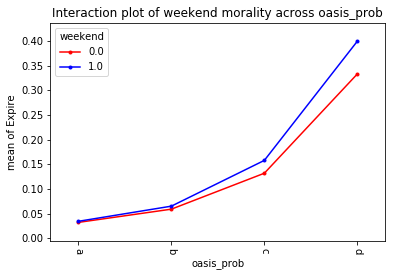

PAIRWISE:
d b 0.009580306953762455
6 total comparisons

Admit_LOC
EMERGENCY ROOM ADMIT    0.885672
TRANSFER                1.516496
REFERRAL                1.974609
Name: log_odds, dtype: float64

value counts
EMERGENCY ROOM ADMIT    591
TRANSFER                264
REFERRAL                248
Name: Admit_LOC, dtype: int64


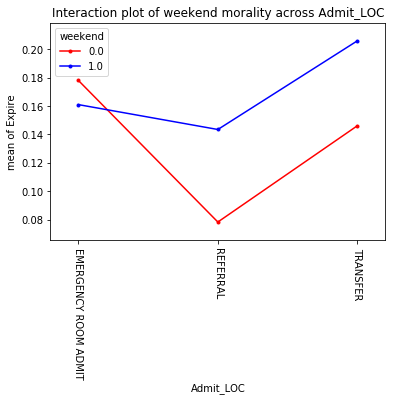

PAIRWISE:
3 total comparisons

Admit_Unit
MICU     1.045546
CCU      1.047383
CSRU     4.287452
TSICU    0.871312
SICU     1.241201
Name: log_odds, dtype: float64

value counts
MICU     530
SICU     218
CCU      153
TSICU    153
CSRU      49
Name: Admit_Unit, dtype: int64


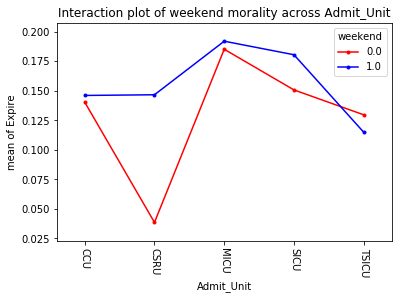

PAIRWISE:
MICU CSRU 0.0014465532120621137
CCU CSRU 0.037038564396132706
CSRU TSICU 0.005790986617668423
CSRU SICU 0.0026334039950629143
10 total comparisons

LOS_ICU
 0.0    1.527937
 2.0    1.280778
 1.0    1.495390
 3.0    1.120473
NaN          NaN
Name: log_odds, dtype: float64

value counts
3.0    446
0.0    257
2.0    227
1.0    173
Name: LOS_ICU, dtype: int64


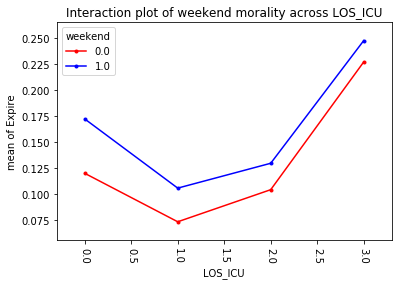

PAIRWISE:
6 total comparisons



In [17]:
for i in sigVars:
    oddsInts(i)
    pairwise(i)
    print()

results = []
for unit_t in df.Admit_Type.unique():
    for unit_l in df.Admit_LOC.unique():
        for l in df.LOS_ICU.unique():
            for unit in df.Admit_Unit.unique():
                w = df[(df.Admit_Type==unit_t) & (df.Admit_LOC==unit_l) & (df.LOS_ICU==l) &  (df.Admit_Unit==unit) & (df.Expire==1) & (df.weekend==1)].shape[0]
                wk = df[(df.Admit_Type==unit_t) & (df.Admit_LOC==unit_l) & (df.LOS_ICU==l) &  (df.Admit_Unit==unit) & (df.Expire==1) & (df.weekend==0)].shape[0]
                results.append((unit_t,unit_l,unit,l,w,wk))
            
results = pd.DataFrame(results)
display(results.sort_values([2,5]))

# show distribution

In [18]:
df[(df.Expire == 1)&(df.weekend == 1)&(df.oasis_prob == 'd')&(df.DiagCodeAbbv == 38)&(df.Admit_Unit == 'MICU')].Admit_LOC.value_counts()

EMERGENCY ROOM ADMIT    58
TRANSFER                32
REFERRAL                20
Name: Admit_LOC, dtype: int64

In [40]:
df.Admit_Type.value_counts()

EMERGENCY    25158
ELECTIVE      4756
URGENT         827
Name: Admit_Type, dtype: int64

In [19]:
def rFishers(df, var):
    nr,nc = pd.crosstab(df.weekend, df[var]).shape
    Br = ro.r.matrix(pd.crosstab(df.weekend, df[var]).values, nrow=nr, ncol=nc)
    print(stats_.fisher_test(Br))

# High oasis - specific treatment (low level)

In [20]:
print(df[(df.Expire == 1)&(df.weekend == 1)&(df.oasis_prob == 'd')&(df.DiagCodeAbbv == 38)&(df.Admit_Unit == 'MICU')&(df.Admit_Type == 'EMERGENCY')].shape)
print(df[(df.Expire == 1)&(df.weekend == 0)&(df.oasis_prob == 'd')&(df.DiagCodeAbbv == 38)&(df.Admit_Unit == 'MICU')&(df.Admit_Type == 'EMERGENCY')].shape)

(103, 26)
(254, 26)


In [21]:
test = df[(df.Expire == 1)&(df.oasis_prob == 'd')&(df.DiagCodeAbbv == 38)&(df.Admit_Unit == 'MICU')&(df.Admit_Type == 'EMERGENCY')]

In [22]:
rFishers(test, 'Admit_LOC')


	Fisher's Exact Test for Count Data

data:  structure(c(145L, 58L, 56L, 19L, 53L, 26L), .Dim = 2:3)
p-value = 0.581
alternative hypothesis: two.sided




In [23]:
rFishers(test, 'LOS_ICU')


	Fisher's Exact Test for Count Data

data:  
p-value = 0.9638
alternative hypothesis: two.sided




In [24]:
rFishers(test, 'Gender')


	Fisher's Exact Test for Count Data

data:  structure(c(126L, 51L, 128L, 52L), .Dim = c(2L, 2L))
p-value = 1
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.6185445 1.6290254
sample estimates:
odds ratio 
  1.003666 




In [25]:
rFishers(test, 'Age')


	Fisher's Exact Test for Count Data

data:  
p-value = 0.9952
alternative hypothesis: two.sided




In [26]:
rFishers(test, 'Ethnicity')


	Fisher's Exact Test for Count Data

data:  
p-value = 0.08752
alternative hypothesis: two.sided




# CSRU - general unit (high level)

In [27]:
print(df[(df.Expire == 1)&(df.weekend == 1)&(df.Admit_Unit == 'CSRU')].shape)
print(df[(df.Expire == 1)&(df.weekend == 0)&(df.Admit_Unit == 'CSRU')].shape)

(49, 26)
(223, 26)


In [28]:
fracs = {'EMERGENCY':82,'ELECTIVE':6,'URGENT':10}
test = df[(df.Admit_Unit == 'CSRU')&(df.Expire == 1)&(df.weekend == 0)]
N = len(test)
test = pd.concat(dff.sample(n=fracs.get(i)) for i,dff in test.groupby('Admit_Type'))
test = test.append(df[(df.Admit_Unit == 'CSRU')&(df.Expire == 1)&(df.weekend == 1)])

In [29]:
test.shape

(147, 26)

In [30]:
rFishers(test, 'Admit_Type')


	Fisher's Exact Test for Count Data

data:  structure(c(6L, 3L, 82L, 41L, 10L, 5L), .Dim = 2:3)
p-value = 1
alternative hypothesis: two.sided




In [31]:
rFishers(test, 'oasis_prob')


	Fisher's Exact Test for Count Data

data:  
p-value = 0.5866
alternative hypothesis: two.sided




In [32]:
rFishers(test, 'Primary_Diag_Code')


	Fisher's Exact Test for Count Data

data:  
p-value = 0.2388
alternative hypothesis: two.sided




In [33]:
rFishers(test, 'Admit_Type')


	Fisher's Exact Test for Count Data

data:  structure(c(6L, 3L, 82L, 41L, 10L, 5L), .Dim = 2:3)
p-value = 1
alternative hypothesis: two.sided




In [34]:
rFishers(test, 'Admit_LOC')


	Fisher's Exact Test for Count Data

data:  structure(c(36L, 16L, 25L, 13L, 37L, 20L), .Dim = 2:3)
p-value = 0.9028
alternative hypothesis: two.sided




In [35]:
rFishers(test, 'LOS_ICU')


	Fisher's Exact Test for Count Data

data:  
p-value = 0.1168
alternative hypothesis: two.sided




In [36]:
rFishers(test, 'Gender')


	Fisher's Exact Test for Count Data

data:  structure(c(46L, 21L, 52L, 28L), .Dim = c(2L, 2L))
p-value = 0.7261
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.5595231 2.5040077
sample estimates:
odds ratio 
  1.178163 




In [37]:
rFishers(test, 'Age')


	Fisher's Exact Test for Count Data

data:  
p-value = 0.1865
alternative hypothesis: two.sided




In [38]:
rFishers(test, 'Ethnicity')


	Fisher's Exact Test for Count Data

data:  
p-value = 0.8373
alternative hypothesis: two.sided




In [39]:
test.Admit_LOC.value_counts()

TRANSFER                57
EMERGENCY ROOM ADMIT    52
REFERRAL                38
Name: Admit_LOC, dtype: int64